In [44]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [45]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


In [46]:
print("Data sebelum augmentasi: ", len(data))

Data sebelum augmentasi:  300


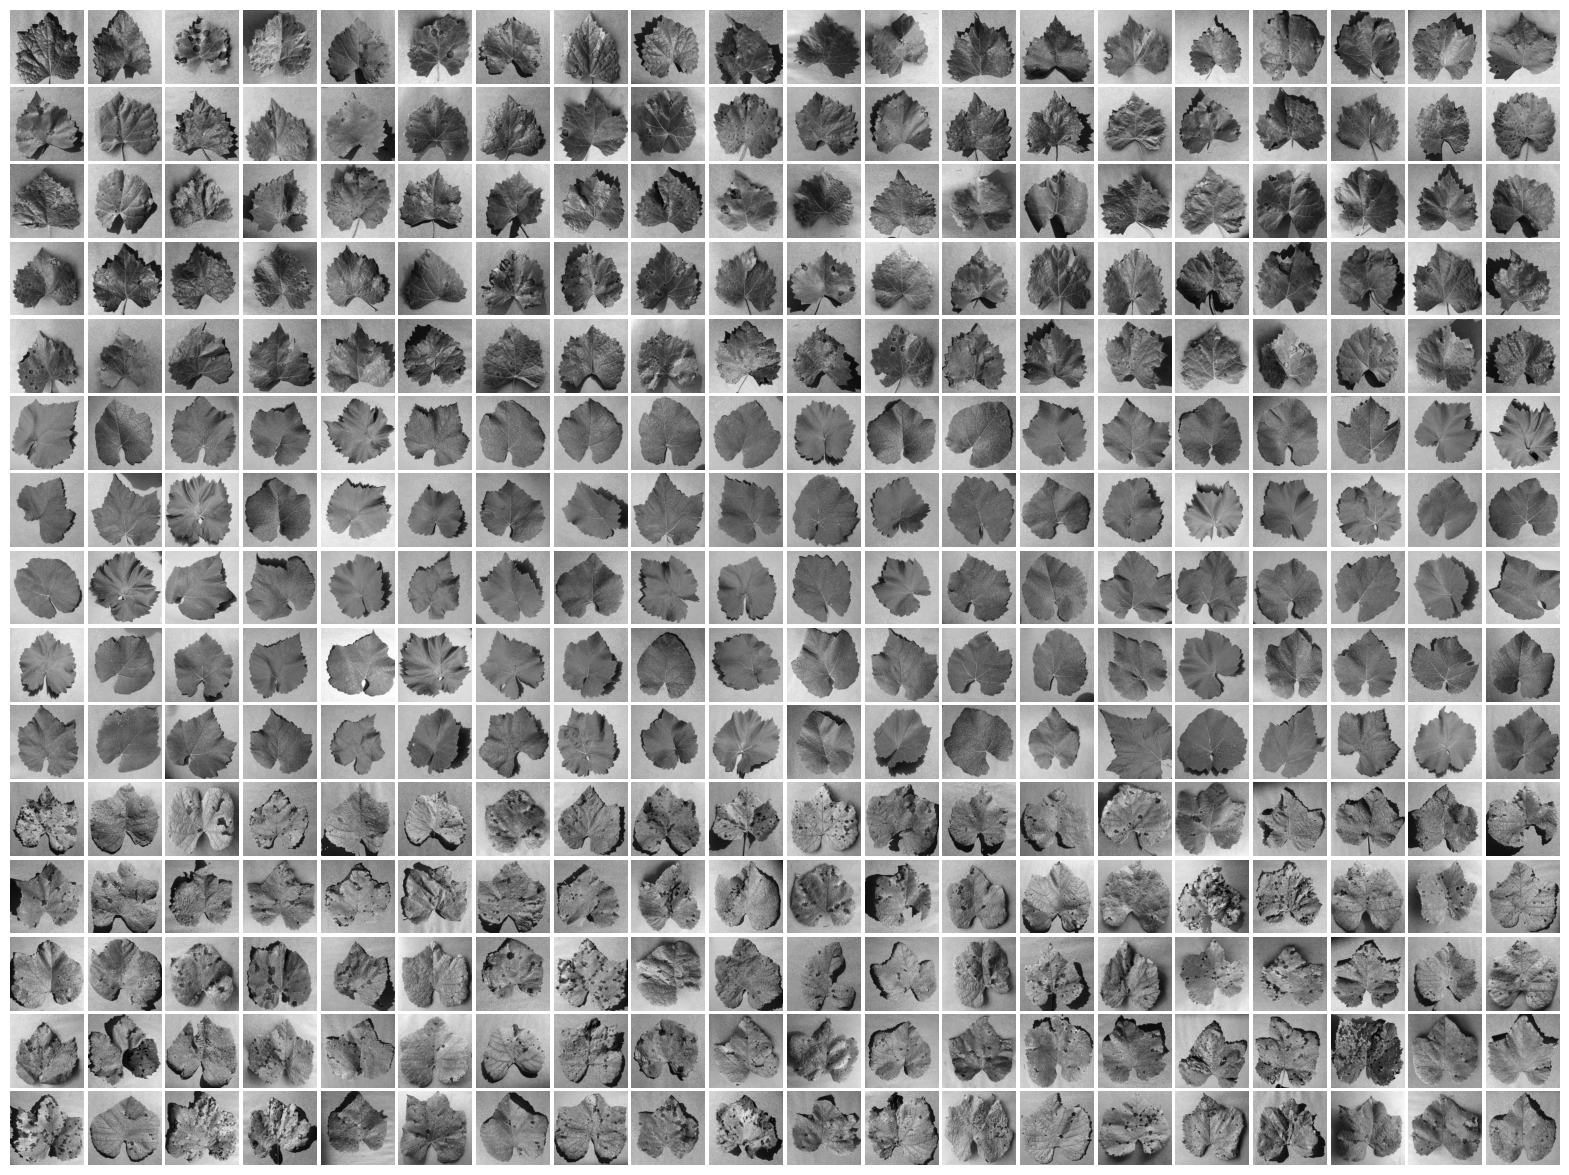

In [106]:
max_display = 300
display_data = data[:max_display]

columns = 20
total = len(display_data)
rows = -(-total // columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(20, 15))

axes_list = axes.ravel() if total > 1 else [axes]

for idx in range(rows * columns):
    ax = axes_list[idx]
    if idx < total:
        ax.imshow(display_data[idx], cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

### Feature Extraction

In [78]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [79]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [80]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [81]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [82]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [83]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [84]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [85]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [86]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data)):
    D0 = glcm(data[i], 0)
    D45 = glcm(data[i], 45)
    D90 = glcm(data[i], 90)
    D135 = glcm(data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [87]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [88]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [89]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [90]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [91]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [92]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [93]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [94]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [95]:
print("Jumlah Filename:", len(file_name))
print("Jumlah Label:", len(labels))
print("Jumlah Kontras0:", len(Kontras0))
print("Jumlah Kontras45:", len(Kontras45))
print("Jumlah Kontras90:", len(Kontras90))
print("Jumlah Kontras135:", len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0))
print("Jumlah Homogeneity45:", len(homogenity45))
print("Jumlah Homogeneity90:", len(homogenity90))
print("Jumlah Homogeneity135:", len(homogenity135))
print("Jumlah Entropy0:", len(entropy0))
print("Jumlah Entropy45:", len(entropy45))
print("Jumlah Entropy90:", len(entropy90))
print("Jumlah Entropy135:", len(entropy135))
print("Jumlah Correlation0:", len(correlation0))
print("Jumlah Correlation45:", len(correlation45))
print("Jumlah Correlation90:", len(correlation90))
print("Jumlah Correlation135:", len(correlation135))


Jumlah Filename: 300
Jumlah Label: 300
Jumlah Kontras0: 300
Jumlah Kontras45: 300
Jumlah Kontras90: 300
Jumlah Kontras135: 300
Jumlah Homogeneity0: 300
Jumlah Homogeneity45: 300
Jumlah Homogeneity90: 300
Jumlah Homogeneity135: 300
Jumlah Entropy0: 300
Jumlah Entropy45: 300
Jumlah Entropy90: 300
Jumlah Entropy135: 300
Jumlah Correlation0: 300
Jumlah Correlation45: 300
Jumlah Correlation90: 300
Jumlah Correlation135: 300


### Write the extraction's results to CSV 

In [96]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,Blackrot (1).JPG,Grape___Black_rot,752.664767,805.452626,703.228125,965.565352,0.075563,0.071505,0.081094,0.063202,...,0.000097,0.000082,0.009648,0.009454,0.009855,0.009035,0.880259,0.871863,0.888224,0.846391
1,Blackrot (100).JPG,Grape___Black_rot,512.448943,559.656778,454.955790,590.805552,0.120552,0.099296,0.116935,0.095646,...,0.000156,0.000131,0.012661,0.011570,0.012490,0.011431,0.921818,0.914689,0.930607,0.909942
2,Blackrot (13).JPG,Grape___Black_rot,266.805990,340.827943,265.487377,327.536332,0.117175,0.092352,0.112740,0.096046,...,0.000222,0.000199,0.015058,0.013983,0.014914,0.014092,0.911644,0.887228,0.912050,0.891626
3,Blackrot (14).JPG,Grape___Black_rot,203.813006,311.644060,197.170236,243.516509,0.146771,0.115090,0.151846,0.123894,...,0.000286,0.000237,0.016523,0.014741,0.016900,0.015381,0.918818,0.875848,0.921359,0.902988
4,Blackrot (15).JPG,Grape___Black_rot,409.081863,449.622284,357.663557,470.452026,0.083544,0.077261,0.092837,0.073594,...,0.000146,0.000127,0.011624,0.011381,0.012068,0.011262,0.896982,0.886765,0.909902,0.881522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Blight (95).JPG,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),442.037868,509.598847,374.421645,483.061745,0.121284,0.096749,0.126249,0.101964,...,0.000237,0.000198,0.015418,0.013857,0.015393,0.014069,0.851900,0.829488,0.874741,0.838366
296,Blight (96).JPG,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),979.991621,1066.276294,813.623836,1030.038108,0.083350,0.076181,0.093031,0.079230,...,0.000181,0.000144,0.012552,0.011999,0.013448,0.012009,0.819808,0.804241,0.850539,0.810893
297,Blight (97).JPG,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),320.551440,349.192049,246.573024,380.937040,0.179573,0.147579,0.187018,0.145242,...,0.000225,0.000172,0.014766,0.013298,0.014988,0.013130,0.943278,0.938209,0.956531,0.932592
298,Blight (98).JPG,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),384.902895,421.122922,345.177512,457.503975,0.105145,0.092771,0.111091,0.088625,...,0.000142,0.000117,0.011629,0.011063,0.011912,0.010826,0.914156,0.906016,0.923133,0.897897


### Features Selection

<Axes: >

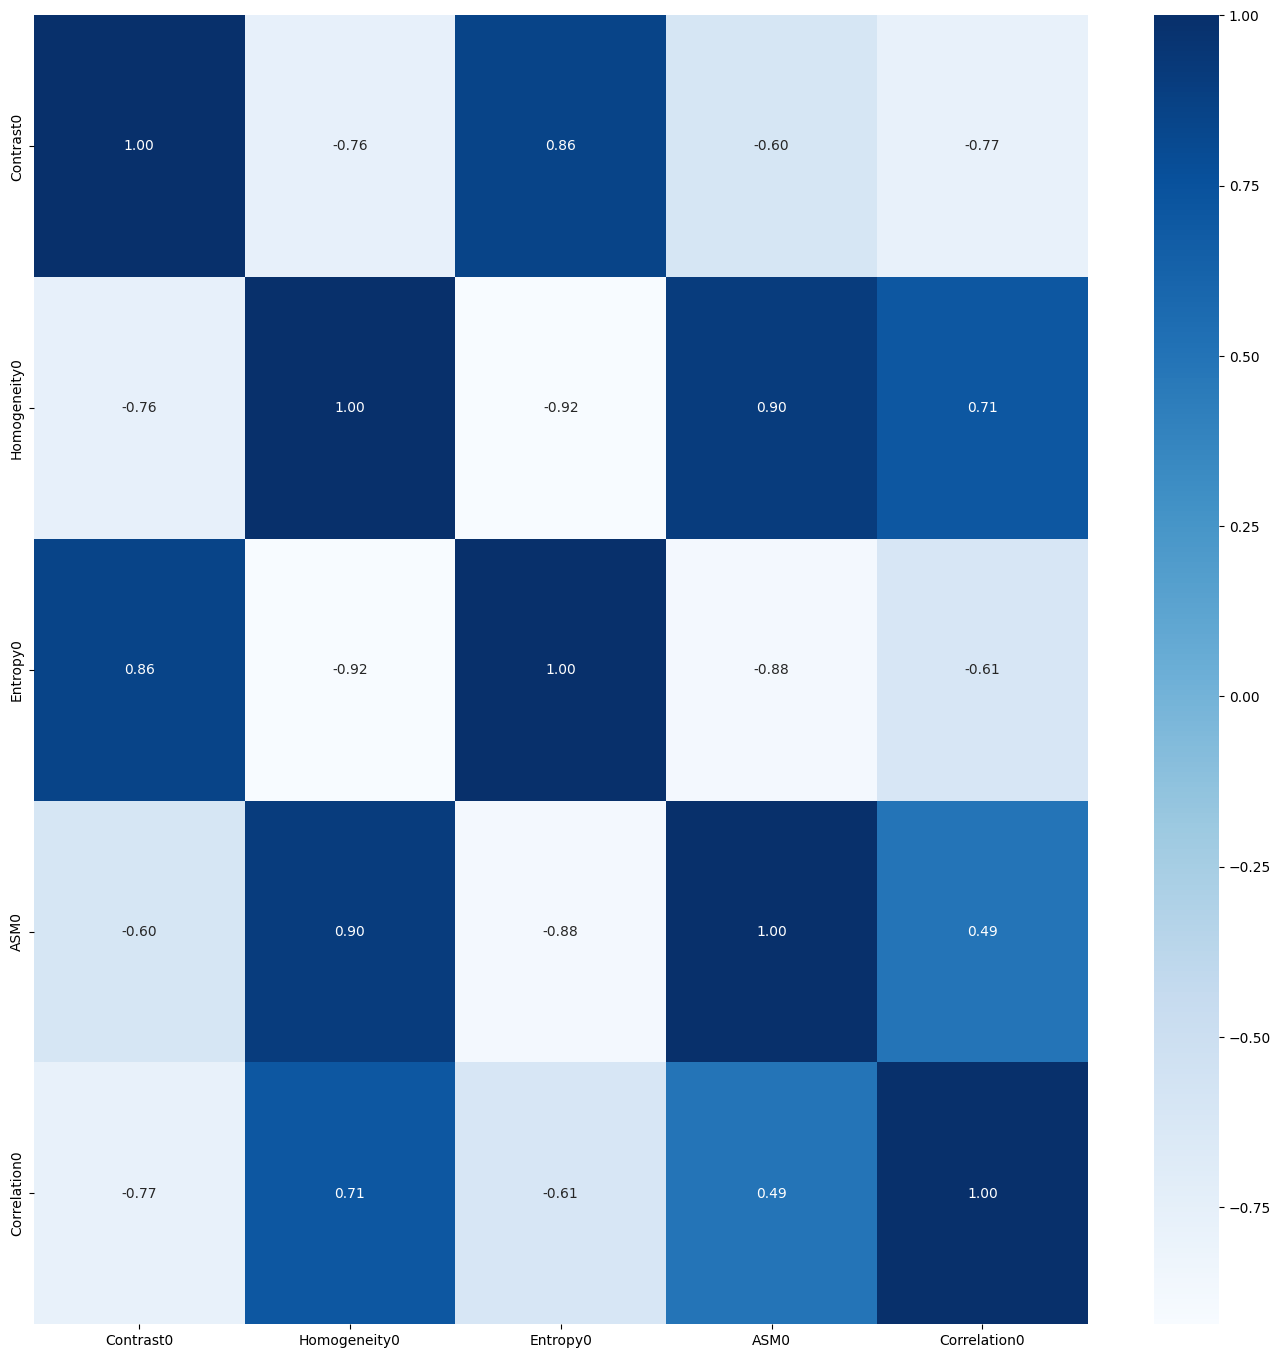

In [97]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [107]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 5)
(60, 5)


## Feature Normalization

In [108]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [109]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=2, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [110]:
rf.fit(X_train, y_train)

print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.83      0.99      0.90        78
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.85      0.91      0.88        78
                           Grape___healthy       0.98      0.74      0.84        84

                                  accuracy                           0.88       240
                                 macro avg       0.89      0.88      0.87       240
                              weighted avg       0.89      0.88      0.87       240

[[77  1  0]
 [ 6 71  1]
 [10 12 62]]
Accuracy: 0.875

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.64      0.64      0.64        22
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.54      0.64      0.58        22
                           Grape___healthy       0.92

### Train SVM Classifier

In [111]:
svm.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.78      0.90      0.83        78
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.68      0.83      0.75        78
                           Grape___healthy       0.98      0.63      0.77        84

                                  accuracy                           0.78       240
                                 macro avg       0.81      0.79      0.78       240
                              weighted avg       0.82      0.78      0.78       240

[[70  7  1]
 [13 65  0]
 [ 7 24 53]]
Accuracy: 0.7833333333333333

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.74      0.77      0.76        22
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.62      0.73      0.67        22
                           Grape___heal

### Train KNN Classifier

In [112]:
knn.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.80      0.90      0.85        78
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.73      0.85      0.78        78
                           Grape___healthy       0.95      0.70      0.81        84

                                  accuracy                           0.81       240
                                 macro avg       0.83      0.82      0.81       240
                              weighted avg       0.83      0.81      0.81       240

[[70  6  2]
 [11 66  1]
 [ 6 19 59]]
Accuracy: 0.8125

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.71      0.77      0.74        22
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.61      0.64      0.62        22
                           Grape___healthy       0.

## Evaluation With Confusion Matrix

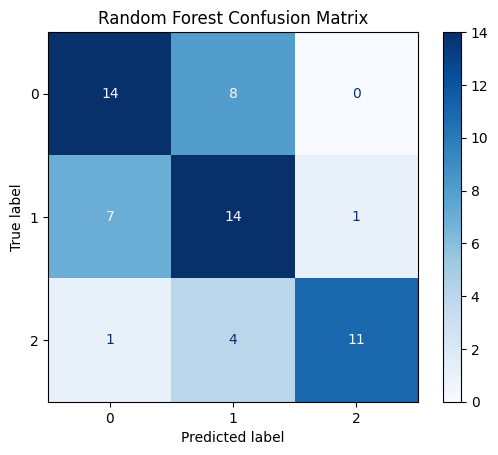

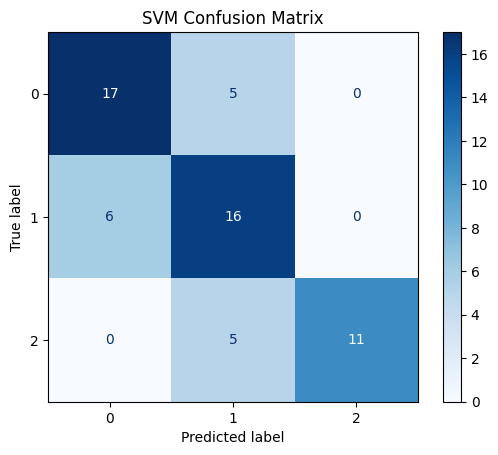

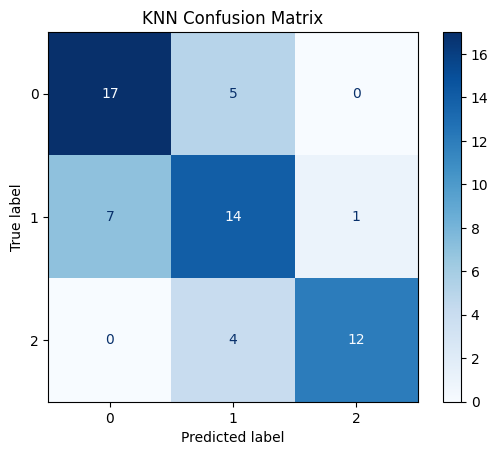

In [113]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")